/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method

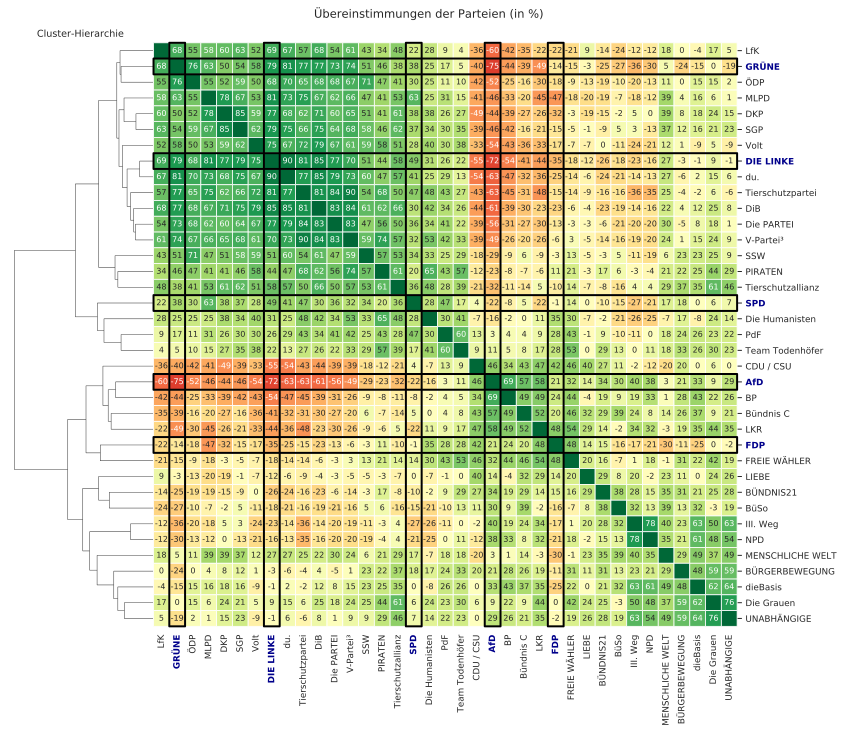

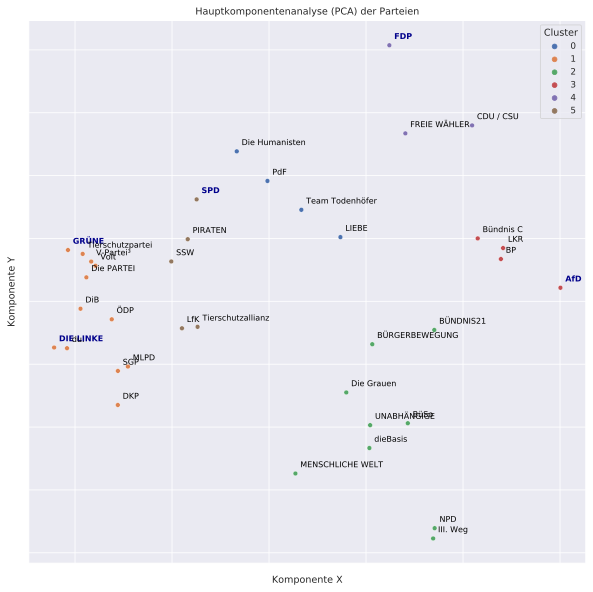

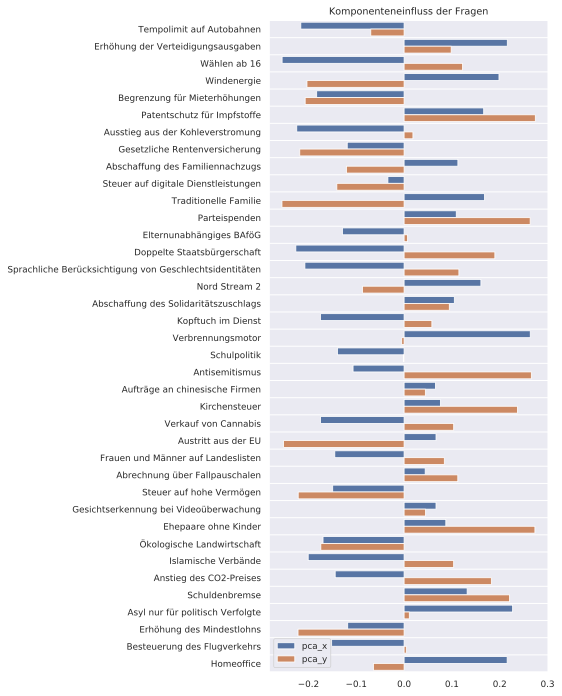

In [1]:
#!/usr/bin/env python
"""Scrapes and analyses www.wahl-o-mat.de political party data.

It generates a correlation matrix and a principal component analysis map,
where also clusters are marked.

The code is inspired by /u/d_loose/ and /u/askLubich/. See:
https://www.reddit.com/r/de/comments/liad93/ich_habe_aus_dem_aktuellen_wahlomat/gn31jpv/
https://github.com/askLubich/
"""

# %% IPython config
# Comment out, if running as a script
%config InlineBackend.figure_format = 'svg'

# %% Import packages
import urllib
import re
import numpy as np
import pandas as pd
from pandas.core.frame import DataFrame
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

# %% Settings
ELECTION: str = "bundestagswahl2021"  # Part of the URL: www.wahl-o-mat.de/ELECTION/...
N_CLUSTERS: int = 6
EMPHASIZED_PARTIES: list = [  # only lowercase (casefold)
    "die linke",
    "linke",
    "die grünen",
    "grüne",
    "spd",
    "fdp",
    "cdu",
    "csu",
    "union",
    "afd",
]


# Set seaborn theme and config
sns.set(rc={"savefig.dpi": 300, "figure.dpi": 300})  # resets style for some reason
sns.set_theme()
sns.set_context("paper")
sns.set_style("darkgrid")

# %% Scrape data
# Download the raw JS data
raw_data_js: str = (
    urllib.request.urlopen(
        f"https://www.wahl-o-mat.de/{ELECTION}/app/definitionen/module_definition.js"
    )
    .read()
    .decode()
)
# Extract the data points with regex
titles: list = re.findall(
    r"^WOMT_aThesen\[\d+\]\[\d+\]\[0] = \'(.+?)\';$", raw_data_js, re.MULTILINE
)
questions: list = re.findall(
    r"^WOMT_aThesen\[\d+\]\[\d+\]\[1] = \'(.+?)\';$", raw_data_js, re.MULTILINE
)
party_names: list = re.findall(
    r"^WOMT_aParteien\[\d+\]\[\d+\]\[0] ?= ?\'(.+?)\';$", raw_data_js, re.MULTILINE
)
party_abbrevs: list = re.findall(
    r"^WOMT_aParteien\[\d+\]\[\d+\]\[1] ?= ?\'(.+?)\';$", raw_data_js, re.MULTILINE
)
raw_answers: list = re.findall(
    r"^WOMT_aThesenParteien\[(\d+)\]\[(\d+)\] ?= ?\'(.+?)\';$",
    raw_data_js,
    re.MULTILINE,
)

# %% Create dataframes
question_df: DataFrame = pd.DataFrame(
    zip(titles, questions), columns=["title", "question"]
)
party_df: DataFrame = pd.DataFrame(
    zip(party_names, party_abbrevs), columns=["full_name", "party"]
)
answer_df: DataFrame = pd.DataFrame(
    raw_answers, columns=["question", "party", "answer"]
).astype("int")
# Exclude bad parties
bad_parties: pd.core.indexes.base.Index = party_df.loc[
    answer_df.groupby("party")["answer"].std() == 0
].index
for party in bad_parties:
    answer_df = answer_df[answer_df["party"] != party]
# Pivot answer dataframe to have parties as columns
answer_df["party_name"] = answer_df["party"].apply(lambda x: party_df.loc[x, "party"])
answer_df = pd.pivot_table(
    answer_df, values="answer", index="question", columns="party_name"
)

# %% Calculate Correlations, PCAs and clusters
answer_corr: DataFrame = answer_df.corr()
corr_overlay: DataFrame = answer_corr.apply(
    lambda s: pd.Series([str(int(100 * x)) if x != 1 else "" for x in s])
)
pca: PCA = PCA(2)
party_pca: DataFrame = pd.DataFrame(
    pca.fit_transform(answer_df.T), columns=["pca_x", "pca_y"], index=answer_df.T.index
)
km: KMeans = KMeans(N_CLUSTERS)
party_pca["cluster"] = km.fit_predict(party_pca)
pca_influences: DataFrame = question_df.join(
    pd.DataFrame(pca.components_.T, columns=["pca_x", "pca_y"])
)

# %% Draw correlation matrix
c_matrix: sns.matrix.ClusterGrid = sns.clustermap(
    data=answer_corr,
    cmap="RdYlGn",
    center=0,
    cbar_pos=None,
    annot=corr_overlay,
    fmt="",
    annot_kws={"fontsize": 8},
    linewidths=0.8,
    figsize=(12, 12),
)
c_matrix.fig.delaxes(c_matrix.ax_col_dendrogram)
c_matrix.ax_heatmap.set(xlabel=None, ylabel=None)
c_matrix.ax_row_dendrogram.set(title="Cluster-Hierarchie")
c_matrix.fig.suptitle("Übereinstimmungen der Parteien (in %)", y=0.86)
# Emphasize specific parties
labels_row: list = c_matrix.ax_heatmap.get_yticklabels()
labels_col: list = c_matrix.ax_heatmap.get_xticklabels()
for party_label in labels_row:
    if party_label.get_text().casefold() in EMPHASIZED_PARTIES:
        party_label.set_color("darkblue")
        party_label.set_fontweight("bold")
        pos_x, pos_y = party_label.get_position()
        c_matrix.ax_heatmap.add_patch(
            Rectangle(
                xy=(pos_x - 1.0, pos_y - 0.5),
                width=len(labels_col),
                height=1,
                fill=False,
                edgecolor="black",
                lw=2,
                clip_on=False,
            )
        )
for party_label in labels_col:
    if party_label.get_text().casefold() in EMPHASIZED_PARTIES:
        party_label.set_color("darkblue")
        party_label.set_fontweight("bold")
        pos_x, pos_y = party_label.get_position()
        c_matrix.ax_heatmap.add_patch(
            Rectangle(
                xy=(pos_x - 0.5, pos_y),
                width=1,
                height=len(labels_row),
                fill=False,
                edgecolor="black",
                lw=2,
                clip_on=False,
            )
        )
# Save as a file
# plt.savefig(f"{ELECTION}_c_matrix.svg", bbox_inches="tight")
plt.show()

# %% Draw PCA map
plt.figure(figsize=(10, 10))
pca_map: plt.Axes = sns.scatterplot(
    data=party_pca, x="pca_x", y="pca_y", hue="cluster", palette="deep"
)
pca_map.set(
    title="Hauptkomponentenanalyse (PCA) der Parteien",
    xlabel="Komponente X",
    ylabel="Komponente Y",
    xticklabels=[],
    yticklabels=[],
)
pca_map.legend(title="Cluster")
# Add labels to the dots
for party_name in party_pca.index:
    color: str = "black"
    fontweight: str = "normal"
    if party_name.casefold() in EMPHASIZED_PARTIES:
        color = "darkblue"
        fontweight = "bold"
    pca_map.text(
        x=party_pca.loc[party_name, "pca_x"] + 0.1,
        y=party_pca.loc[party_name, "pca_y"] + 0.1,
        s=party_name,
        color=color,
        fontweight=fontweight,
        fontsize="small",
    )
# Save as a file
# plt.savefig(f"{ELECTION}_pca_map.svg", bbox_inches="tight")
plt.show()

# %% Draw PCA influence barplot
plt.figure(figsize=(5, 12))
inf_barplot: plt.Axes = sns.barplot(
    data=pca_influences.melt(
        id_vars=["title"],
        value_vars=["pca_x", "pca_y"],
        var_name="component",
        value_name="influence",
    ),
    x="influence",
    y="title",
    hue="component",
    orient="h",
)
inf_barplot.set(title="Komponenteneinfluss der Fragen", xlabel=None, ylabel=None)
inf_barplot.legend(title=None, loc='upper right')
inf_barplot.set_yticks(
    np.arange(-0.5, len(inf_barplot.get_yticks(minor=False)), 1), minor=True
)
inf_barplot.grid(False, axis="x")
inf_barplot.grid(True, which="minor", axis="y", linewidth=1)
# Save as a file
# plt.savefig(f"{ELECTION}_pca_influences.svg", bbox_inches="tight")
plt.show()
